In [1]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import time
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter


In [2]:
# Tensorboard
writer = SummaryWriter('runs/exp4')

In [3]:
#EXPERIMENT PARAMETERS

experiment_no = 12
features_path = r"/home/local/ASURITE/speddira/dev/archived/traffic_sense_net/city_scale/CNN_DNN/data/dataset4/features"
labels_path = r"/home/local/ASURITE/speddira/dev/archived/traffic_sense_net/city_scale/CNN_DNN/data/dataset4/labels"

In [4]:
set_seed = True

seed = 20
if set_seed:
    print("Setting seed for the experiment")
    # Set seed for CPU and all GPUs (if available)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

Setting seed for the experiment


In [5]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()

        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Convert inputs and targets to probabilities
        
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        targets = torch.argmax(targets,axis=1)
        
        alpha = self.alpha[targets].to(inputs.device)

        
        # Calculate pt
        pt = torch.exp(-ce_loss)
        # Calculate Focal Loss
        focal_loss = alpha * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:  # 'none'
            return focal_loss

In [6]:
class TrafficDataset(Dataset):
    def __init__(self, directory,label_directory):
        
        self.files = [os.path.join(directory, f) for f in sorted(os.listdir(directory))] #[0:100]
        # self.travel_time_files = [os.path.join(travel_time_directory, f) for f in sorted(os.listdir(travel_time_directory))]
        self.yfiles= [os.path.join(label_directory, f) for f in sorted(os.listdir(label_directory))] #[0:100]
        self.num_files = len(self.files)
        
        self.total_sequences = self.num_files # * self.sequences_per_file
        
    def __len__(self):
        return self.total_sequences
    
    def __getitem__(self, index):
        
        file_index = index 
        
        data = np.load(self.files[file_index]) #Loads the file which contains our desired sequence
        label_data = np.load(self.yfiles[file_index])
        # travel_time_data = np.load(self.travel_time_files[file_index])

        sequence = np.transpose(data, (2, 0, 1)) # To orient in the dimension with 3 channels being first
        
        #When majority class is important
        # label_data_summed = np.sum(label_data,axis=0)
        # indx = np.argmax(label_data_summed)
        # labelsWindow = np.zeros(13)
        # labelsWindow[indx] = 1
        
        
        #When latest trend is important
        # last_row = label_data[-1:]
        # indx = np.argmax(last_row)
        # labelsWindow = np.zeros(13)
        # labelsWindow[indx] = 1
        
        # Just checking if it can predict accident or not based on latest row class
        last_row = label_data[-1:]
        indx = np.argmax(last_row)
        labelsWindow = np.zeros(2)
        if indx != 12:
            labelsWindow[0] = 1 # Accident true 
        else:
            labelsWindow[1] = 1 # Accident false
        
        
        # Travel Time lets take the last row row
        
        # travel_time_data = travel_time_data[-1]
        
        return torch.tensor(sequence, dtype=torch.float32),torch.tensor(labelsWindow, dtype=torch.float32)#,torch.tensor(travel_time_data, dtype=torch.float32)

In [7]:
print(f"Is CUDA available : {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA available : True


In [8]:
class CNNEncoder(nn.Module):
    def __init__(self, features: int):
        super(CNNEncoder, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=features, out_channels=32, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv_pool1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2))
        self.bn1 = nn.BatchNorm2d(32)
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv_pool2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,2), stride=(1,2))
        self.bn2 = nn.BatchNorm2d(64)

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1,3), padding=(0,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv_pool3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1,2), stride=(1,2))
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.block_1(x)
        x = self.bn1(self.conv_pool1(x))
        x = self.block_2(x)
        x = self.bn2(self.conv_pool2(x))
        x = self.block_3(x)
        x = self.bn3(self.conv_pool3(x))

        return x

class LSTMDecoder(nn.Module):
    def __init__(self):
        super(LSTMDecoder, self).__init__()
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, num_layers=2, batch_first=True)
        self.ln1 = nn.LayerNorm(128)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, num_layers=2, batch_first=True)
        self.ln2 = nn.LayerNorm(128)
        self.lstm3 = nn.LSTM(input_size=128, hidden_size=128, num_layers=2, batch_first=True)
        self.ln3 = nn.LayerNorm(128)
        self.lstm4 = nn.LSTM(input_size=128, hidden_size=128, num_layers=2, batch_first=True)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.ln1(x)
        x, _ = self.lstm2(x)
        x = self.ln2(x)
        x, _ = self.lstm3(x)
        x = self.ln3(x)
        x, _ = self.lstm4(x)
        return x

class ComplexCNNLSTMModel(nn.Module):
    def __init__(self):
        super(ComplexCNNLSTMModel, self).__init__()
        self.conv_encoder = CNNEncoder(features=3)  # ADDED NOW
        self.lstm_decoder = LSTMDecoder()

        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 2)  # Assuming 14 is the number of classes

    def forward(self, x):
        batch_size, F, T, S = x.size()

        x = self.conv_encoder(x) # ADDED NOW
        # Apply Global Average Pooling over the sensor dimension only
        x = x.mean(dim=-1)
        x = x.transpose(1, 2)
        x = self.lstm_decoder(x)
        x = self.fc1(x[:, -1, :])
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x

In [9]:
# Train - Test splits

dataset = TrafficDataset(features_path,labels_path)

# Calculate the lengths of splits
total_size = len(dataset)
train_size = int(0.9 * total_size)
test_size = total_size - train_size

print(f"Train size is : {train_size}")
print(f"Test size is : {test_size}")

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for both datasets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0) # num of workers = 0 in windows
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0) # Shuffle is usually False for testing/validation



Train size is : 19420
Test size is : 2158


In [10]:
# classes_count_dict = {
#     0:0,
#     1:0,
#     2:0,
#     3:0,
#     4:0,
#     5:0,
#     6:0,
#     7:0,
#     8:0,
#     9:0,
#     10:0,
#     11:0,
#     12:0
# }
classes_count_dict   = {
    0:0,
    1:0
}

for i,(input,labels) in enumerate(train_dataloader):

    _, labels_indices = torch.max(labels, 1)

    for index in labels_indices:
        # print(int(index.numpy()))
        classes_count_dict[int(index.numpy())]+=1


print(classes_count_dict)
class_counts = []
for key in classes_count_dict.keys():

    class_counts.append(classes_count_dict[key])

weights = 1.0 / torch.tensor(class_counts, dtype=torch.float,device=device)
weights = weights / weights.min()


{0: 8249, 1: 11171}


In [11]:
weights

tensor([1.3542, 1.0000], device='cuda:0')

In [12]:
num_epochs  = 40

n_classes = 2

model = ComplexCNNLSTMModel()

loss_function = nn.CrossEntropyLoss(weight=weights)
# loss_function = FocalLoss(alpha=weights, gamma=3)
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
# Move model to GPU if available
model.to(device)
correct_predictions_per_class = torch.zeros(n_classes, device=device)
actual_per_class = torch.zeros(n_classes, device=device)

In [13]:
# summary(model, input_size=train_dataloader[0].shape)

In [14]:
print(f"Device used is {device}")

Device used is cuda


In [15]:
global_step = 0
training_loss_data = [] # Stores total training loss for each epoch
testing_loss_data = [] # Stores total testing loss for each epoch
epochs = []
training_time = 0 # Stores the total training time

In [16]:
num_epochs = 40

In [17]:
print(f"Training started for {num_epochs} epochs")

for epoch in range(num_epochs):
    
    epochs .append(epoch) 
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    start_time = time.time()
    total_predictions =0
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        inputs, labels = inputs.to(device), labels.to(device) # Move data to the device
        optimizer.zero_grad()

        # Forward pass
        # print(inputs.shape)
        # print(travel_time.shape)
        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()


        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        _, labels_indices = torch.max(labels, 1)
        total_samples += labels.size(0)
        
        predicted = predicted.to(labels_indices.device).long() 
        labels_indices = labels_indices.to(predicted.device).long()

        correct_predictions += (predicted == labels_indices).sum().item()
        total_predictions = total_predictions+32
        
        for class_index in range(n_classes):
            correct_predictions_per_class[class_index] += ((predicted == labels_indices) & (labels_indices == class_index)).sum()
            actual_per_class[class_index] += (labels_indices == class_index).sum()

        if i % 150 == 0:  # Log every 10 batches
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(train_dataloader)}, Partial Loss: {running_loss/(i+1):.4f}, Correct Predictions: {correct_predictions}/{total_predictions}")
            

        global_step+=1
        
    # before_lr = optimizer.param_groups[0]["lr"]
    # scheduler.step()
    # after_lr = optimizer.param_groups[0]["lr"]
    
    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(train_dataloader)
    training_loss_data.append(epoch_loss)
    epoch_accuracy = (correct_predictions / total_samples) * 100
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds.")
    # print(f"Before Learning rate {before_lr}, After Learning rate {after_lr}")
    
    print(f"Epoch {epoch+1} Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    writer.add_scalar("Loss/train",epoch_loss, global_step) # Writing to tensorboard
    # Testing phase ---------------------------------------------------------------------------
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation
        correct_test_predictions = 0
        total_test_samples = 0
        test_loss = 0
        for test_inputs, test_labels in test_dataloader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)  
            outputs = model(test_inputs)
            loss = loss_function(outputs, test_labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += test_labels.size(0)
            _, labels_indices = torch.max(test_labels, 1)

            correct_test_predictions += (predicted == labels_indices).sum().item()
    testing_loss_data.append(test_loss/len(test_dataloader))
    test_accuracy = (correct_test_predictions / total_test_samples) * 100
    print(f"Epoch {epoch+1} Test Accuracy: {test_accuracy:.2f}% Test Loss {test_loss/len(test_dataloader)}\n")

writer.flush()
writer.close()



Training started for 40 epochs


Epoch 1, Batch 1/1214, Partial Loss: 0.7885, Correct Predictions: 6/32
Epoch 1, Batch 151/1214, Partial Loss: 0.7960, Correct Predictions: 1286/4832


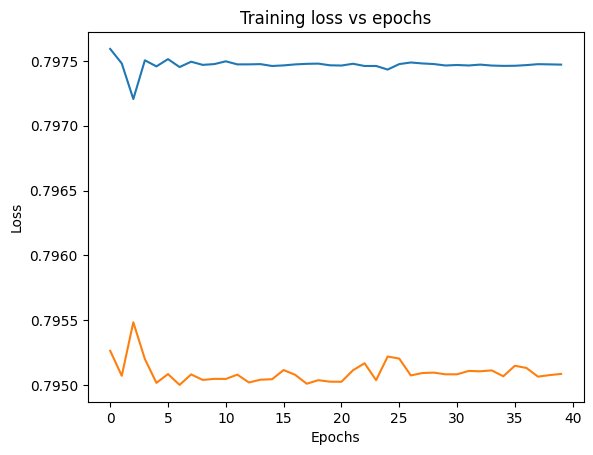

In [ ]:
# Training loss vs epochs
plt.plot(epochs,training_loss_data)
plt.plot(epochs,testing_loss_data)
plt.title("Training loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

     

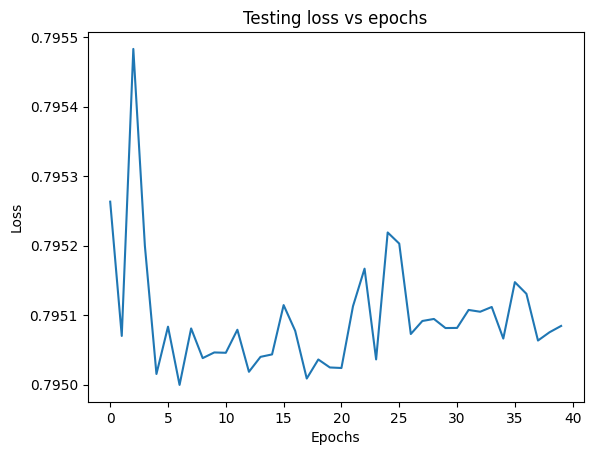

In [ ]:
# Testing loss vs epochs
plt.plot(epochs,testing_loss_data)
plt.title("Testing loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [ ]:
# Running evaluation on test model again
true_labels = []
predictions = []
with torch.no_grad():
    for inputs, labels,traveltime in test_dataloader:
        test_inputs, test_labels,test_time = inputs.to(device), labels.to(device)  ,traveltime.to(device)
        outputs = model(test_inputs,test_time) # Get model outputs for the current batch
        _, predicted = torch.max(outputs, 1) # Get the index of the max log-probability
        _, ground_truth = torch.max(labels, 1)
        # Store predictions and true labels
        true_labels.extend(ground_truth.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())




In [ ]:
# Confusion matrix
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
# to get heat map
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[   0  897]
 [   0 1261]]


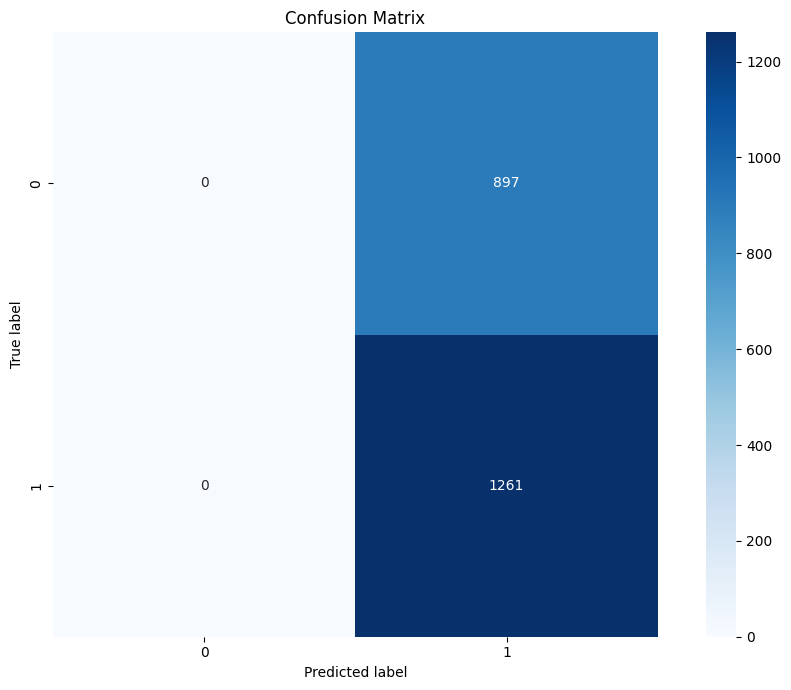

In [ ]:
plt.figure(figsize=(10, 7))

# Draw the heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=range(np.unique(true_labels).size),
            yticklabels=range(np.unique(true_labels).size))

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# F1 score and other metrics

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")




Precision: 0.3414501379010016, Recall: 0.5843373493975904, F1: 0.4310321132438499


/mnt/sda1/labdata/sai/traffic_sense_net_archived/environments/pyenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Saving model

torch.save(model, f"saved_models/V{experiment_no}/model.pth")
with open(f"saved_models/V{experiment_no}/README.md","w") as f:
    f.write(f"Model details:\n")
    f.write(f"Train accuracy : {epoch_accuracy}\n")
    f.write(f"Test accuracy : {test_accuracy}\n")
    f.write(f"Precision : {precision}\n")
    f.write(f"Recall : {recall}\n")
    f.write(f"F1 : {f1}\n")

RuntimeError: Parent directory saved_models/V11 does not exist.

In [ ]:
print(f"Model details:")
print(f"Train accuracy : {epoch_accuracy}")
print(f"Test accuracy : {test_accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 : {f1}\n")

Model details:
Train accuracy : 51.637487126673534
Test accuracy : 52.502316960148285
Precision : 0.6041351653820396
Recall : 0.5250231696014829
F1 : 0.4961052138651795



In [ ]:
# Running evaluation on test model again
true_labels = []
predictions = []
with torch.no_grad():
    for inputs, labels,traveltime in test_dataloader:
        test_inputs, test_labels,test_time = inputs.to(device), labels.to(device)  ,traveltime.to(device)
        outputs = model(test_inputs,test_time) # Get model outputs for the current batch
        _, predicted = torch.max(outputs, 1) # Get the index of the max log-probability
        _, ground_truth = torch.max(labels, 1)
        # Store predictions and true labels
        print(predicted)
        
        
        break




tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
